# Part 3: ???

**Previously**

Set up a 2d view into an n-dimensional data source.  A sampling function provided
by the data source mapped points in **screen space** to the **view space** to the 
n-dimensional **data space**.

**In this part**

Controls on the view.

In [1]:
# prelude
from numpy import zeros,array,pi,cos,sin,eye,meshgrid,arange
from pylab import imshow,rand,figure
from functools import reduce
from typing import List
from ipywidgets import interactive

def xor_image(shape):
    dims = meshgrid(*tuple([arange(dim) for dim in shape]))
    return reduce(lambda acc, coord: acc ^ coord, dims)

class Data:
    def __init__(self, sz):
        self._data=zeros(sz)
        self._ndim=len(sz)+1 # add 1 for affine
        
        # Here, the view space is expected to be 3d+1
        # The *rows* can be permuted to change ordering of the source data dims
        # The *columns* can be permuted to change the ordering of the view dimensions
        self._transform=eye(self._ndim,4)
        self._transform[:,-1]=[0,0,0,1]
        
        self._data=0.04*xor_image(sz) # scale intensities
                    
    def slice(self,starts,stops,steps)->"Data":
        slices = [slice(a,b,c) for a,b,c in zip(starts,stops,steps)]
        data = self._data[tuple(slices)]
        xform = self._transform.copy()
        xform[:-1,-1]=[-s for s in starts]
        d=Data(data.shape)
        d._data=data;
        d._transform=xform
        return d
        
    def sample(self,r):
        # r: 4x1 vector - "view" coordinate - 3D + 1
        
        def inbounds(rr,sh):
            # determine if rr is inside the box described by sh 
            # (which is the w,h,d.. of the box)
            v = all([0<=x<hi for x,hi in zip(rr,sh)])
            return v
        

        #               [(D+1)x4] x [4X1]
        r_data = (self._transform @ array(r)).astype(int)[:-1]         

        if inbounds(r_data,self._data.shape):
            return self._data[tuple(r_data)]
        else: 
            return None
    
    def translate(self,dr):
        d=Data(self._data.shape)
        d._data=self._data;
        xform=self._transform.copy()
        xform[:-1,-1]=-dr;
        d._transform=xform
        return d
    
    def rotate_and_other_stuff(self,theta_deg):
        theta_rad=theta_deg*pi/180.0
        c,s = cos(-theta_rad),sin(-theta_rad)
        #4x4
        S = eye(4)*0.3
        R = array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]])
        #4x3
        xform = R @ S @ self._transform        
        d=Data(self._data.shape)
        d._data=self._data;
        d._transform=xform
        return d


## View

In [2]:
class View:
    def __init__(self, w: int, h: int):
        self.w=w
        self.h=h
        self._data=[]
        # view space is 3d
        # screen space is 2d
        
        self._bg=rand(self.h,self.w)
        
        self._theta_deg=0
        self._dz=0
        self._update_xform()
        
    def add_data(self, d):
        self._data.append(d)
        
    def render(self,frame):
        for y in range(0,frame.shape[0]):
            for x in range(0,frame.shape[1]):
                r_samp=self._transform@[x,y,1] # screen space: 2d+1
                for d in self._data:
                    v = d.sample(r_samp)
                    if v is not None:
                        frame[y,x]=v
    
    def _update_xform(self):
        theta_rad=self._theta_deg*pi/180.0
        c,s = cos(-theta_rad),sin(-theta_rad)
        T=array([[1,0,-self.w//2],[0,1,-self.h//2],[0,0,self._dz],[0,0,1]])
        invT=array([[1,0,0,self.w//2],[0,1,0,self.h//2],[0,0,1,0],[0,0,0,1]])
        R=array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]])
        self._transform=invT@R@T
        
    def rotate(self, theta_deg):
        self._theta_deg=theta_deg
        self._update_xform()
        
    def translate_z(self,z):
        self._dz=z
        self._update_xform()
        
    
    def show(self):
        frame=self._bg.copy()
        self.render(frame)
        #figure()
        imshow(frame)
    

There are a few things to notice:
1. The transform only has to care about 2d things. It doesn't have to know 
   anything about the dimensionality of the data sources.
2. The transform affects the sampling of all the bound data sources the same 
   way.  It didn't have to.  We could have chosen some other scheme, but we
   chose this one because that's how we wanted the transform to work - we 
   wanted it to move all view so all the data appeared to move together. This
   is one reason the view transform is kept separate from the data transform.

## Results
That's it! Lets try it out:

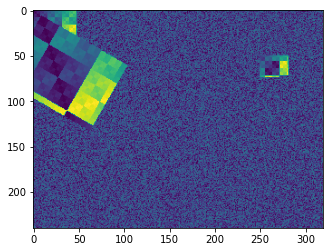

In [3]:
d=Data((64,48,33))
data=d.slice([10,10,0],[42,34,33],[1,1,1])
data1=data.rotate_and_other_stuff(30)
data2=data.translate(array([250,50,-10])) # n-dimension translation

v=View(320,240)
v.add_data(d)
v.add_data(data1)
v.add_data(data2)
v.show()

In [4]:
def doit(theta,z):
    v.rotate(theta)
    v.translate_z(z)
    v.show()
interactive_plot = interactive(doit, theta=(-180,180), z=(0,32))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=0, description='theta', max=180, min=-180), IntSlider(value=16, descript…

## Summary

Composing the view and data transforms makes it clear how the translations in each space relate even though $\vec{t}_{data}$ and $\vec{t}_{view}$ have different sizes (d-dimensional vs 2-dimensional).

$$
\underset
{(d+1)\times 3}
{
\left[
\begin{array}{c|c}
\mathbf{A} & \vec{t}_{data} \\
\hline
0 & 1 \\
\end{array}
\right]
}
\underset
{3\times3}
{
\left[
\begin{array}{c|c}
\mathbf{B} & \vec{t}_{view} \\
\hline
0 & 1 \\
\end{array}
\right]
}
=
\underset
{(d+1)\times 3}
{
\left[
\begin{array}{c|c}
\mathbf{A}\mathbf{B} & \mathbf{A}\vec{t}_{view}+\vec{t}_{data} \\
\hline
0 & 1 \\
\end{array}
\right]
}
$$

### Naming spaces

There's an important question that pops up at this point.  What do we _call_
the spaces these matrices map between? It's convenient to have a consistent
set of names since these are some of the important moving pieces in our
rendering machine.  Here are some name's that make sense to me:

On the far left-hand side, we have coordinates that index into a data set: the
**data space**.  On the far right-hand side, we have the coordinates of the
pixels we want to paint: that might get called the **screen space**.  

The space in-between is the **view space**.  This is some virtual space
defined by the view transform.  The view transform determines where the
origin, scale and rotation of the _view_ relative to the _screen_. Here it has
the same dimensionality as the screen, but it doesn't have to. In the next
part we'll see what that means.  For now, we can write:

$$
r_{data} = \mathbf{T}_{dv}\mathbf{T}_{vs}r_{screen}
$$

where $\mathbf{T}_{dv}$ is the _view_ to _data_ transform, and $\mathbf{T}_{vs}$
is the  _screen_ to _view_ transform.

### Other spaces

One reason the names are important is because people use a variety of names
and it's easy to confuse them. There are also other spaces of interest that
we want to be able to discuss.  These might be _world_ or _physical_ spaces.
Often there is a common coordinate system where a sample is multiply imaged.
The different data sets might all be related to this _sample_ space. 

Each of these spaces are sometimes used when discussing what I've termed the 
_view_ space above. Often the view is thought to have a direct correspondence
with e.g. the _sample_ space that makes them conceptually the same. But I'm
going to draw a distinction here and say that the _view_ space is defined by
it's requirements relative to how the `View` operates. The other spaces are
distinguished by relationships between the data and an outside world.

How does these correspond to the names used in the `napari` code base?

| Here   | napari |
| ----   | -----  |
| view   | world  |
| data   | layer  |
| screen | canvas |